In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path1 = "/Users/sethfried/Fantasy Football/Cleaned Data/ADP/"
path2 = "_adp_mock.csv"
years = range(2012, 2025)
adp_dfs = {}

for year in years:
    df = pd.read_csv(f"{path1}{year}{path2}")
    df['POS'] = df['POS'].str.strip().str.extract(r'([A-Z]+)')
    df['Rank'] = df.groupby('POS')['Rank'].rank(method='min').fillna(0).astype(int)
    adp_dfs[year] = df

def calculate_points(row):
    points = 0
    points += row.get("pass_yds", 0) / 25
    points += row.get("pass_td", 0) * 4
    points += row.get("rush_yds", 0) / 10
    points += row.get("rush_td", 0) * 6
    points += row.get("rec_yds", 0) / 10
    points += row.get("rec_td", 0) * 6
    points += row.get("fumbles", 0) * -2
    points += row.get("pass_int", 0) * -2
    return points

pos = ["qb", "rb", "te", "wr"]
dfs = []

for position in pos:
    
    df = pd.read_csv(f"/Users/sethfried/Fantasy Football/Cleaned Data/Player_Season_stats/{position}_season_stats")
    df["POS"] = position.upper()
    dfs.append(df)
    

stats_df = pd.concat(dfs, ignore_index=True)
stats_df = stats_df.fillna(0)
stats_df = stats_df.dropna(how="all")
stats_df = stats_df.drop_duplicates()
stats_df = stats_df.rename(columns={"Year_x": "Year"})

stats_df["Points"] = stats_df.apply(calculate_points, axis=1)
stats_df['Rank'] = stats_df.groupby('POS')['Points'].rank(ascending=False, method='min').astype(int)

def compare_adp_vs_actual_rank(adp_dfs, stats_df):
    all_years_results = []
    
    for year, adp_df in adp_dfs.items():
        if year in stats_df['Year'].unique():
            stats_year = stats_df[stats_df['Year'] == year].copy()
            
            adp_df['Player'] = adp_df['Player Team (Bye)'].str.extract(r'^([^\(]+)').iloc[:, 0].str.strip()
            adp_df_clean = adp_df[['Player', 'POS', 'AVG']].rename(columns={'AVG': 'ADP'})
            
            merged_df = pd.merge(stats_year, adp_df_clean, on=['Player', 'POS'], how='inner')
            
            if merged_df.empty:
                print(f"No players matched for year {year}")
                continue

            merged_df['ADP_Rank'] = merged_df.groupby('POS')['ADP'].rank(method='min').astype(int)
            merged_df['Actual_Rank'] = merged_df.groupby('POS')['Points'].rank(ascending=False, method='min').astype(int)
            merged_df['Rank_Diff'] = merged_df['ADP_Rank'] - merged_df['Actual_Rank']
            
            final_df = merged_df[['Year', 'Player', 'POS', 'Team', 'ADP_Rank', 'Actual_Rank', 'Rank_Diff', 'Points']]
            all_years_results.append(final_df)
    
    if all_years_results:
        return pd.concat(all_years_results, ignore_index=True)
    else:
        print("No matching data")
        return pd.DataFrame()

combined_results = compare_adp_vs_actual_rank(adp_dfs, stats_df)
print(combined_results.head(50))

    Year                 Player POS Team  ADP_Rank  Actual_Rank  Rank_Diff  \
0   2012          Aaron Rodgers  QB  GNB         1            1          0   
1   2012             Alex Smith  QB  SFO        15           20         -5   
2   2012            Andrew Luck  QB  IND        13            8          5   
3   2012     Ben Roethlisberger  QB  PIT        10           11         -1   
4   2012         Blaine Gabbert  QB  JAX        24           22          2   
5   2012         Brandon Weeden  QB  CLE        23           17          6   
6   2012             Cam Newton  QB  CAR         4            4          0   
7   2012       Christian Ponder  QB  MIN        22           14          8   
8   2012             Drew Brees  QB  NOR         3            2          1   
9   2012            Eli Manning  QB  NYG         6           10         -4   
10  2012            Jake Locker  QB  TEN        16           19         -3   
11  2012             Jay Cutler  QB  CHI        11           15 

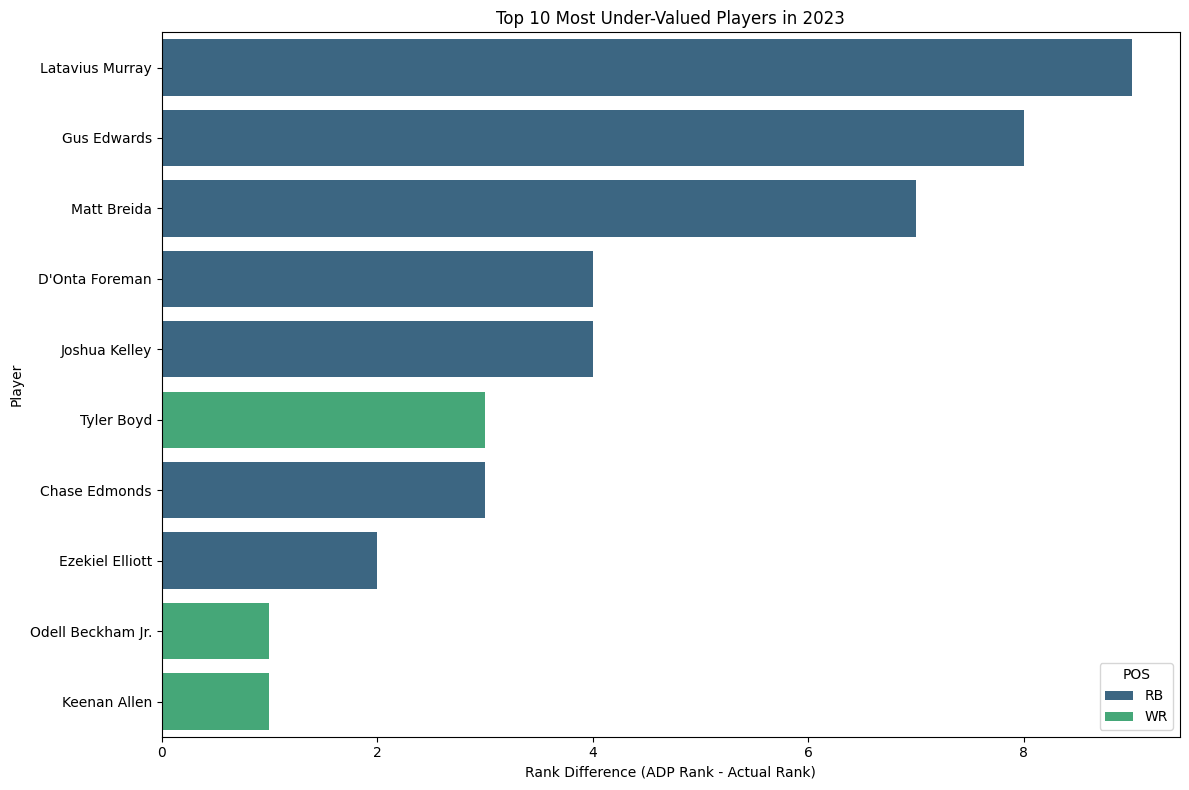

In [2]:
year_to_plot = 2023
under_valued = combined_results[combined_results['Year'] == year_to_plot].sort_values('Rank_Diff', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=under_valued,
    x='Rank_Diff',
    y='Player',
    hue='POS',
    palette='viridis'
)

plt.title(f'Top 10 Most Under-Valued Players in {year_to_plot}')
plt.xlabel('Rank Difference (ADP Rank - Actual Rank)')
plt.ylabel('Player')
plt.tight_layout()
plt.savefig(f'under_valued_players_{year_to_plot}.png')
plt.show()

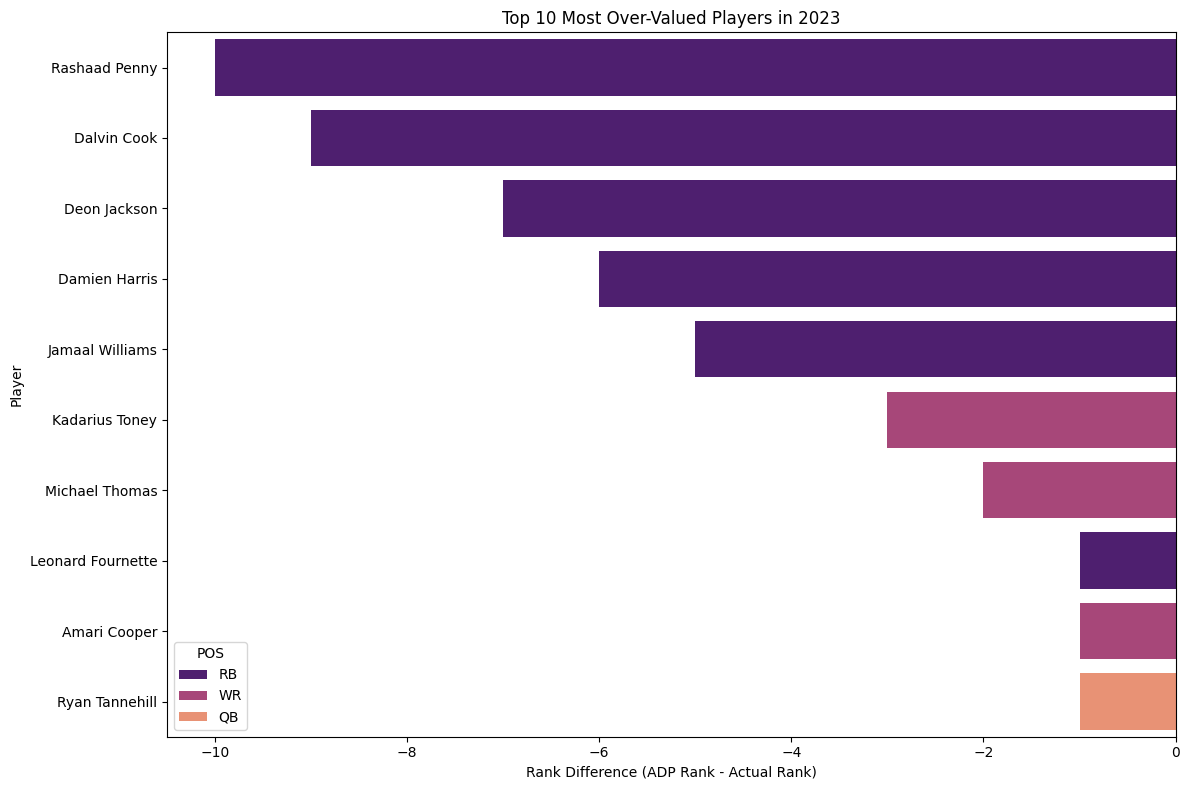

In [3]:
year_to_plot = 2023
over_valued = combined_results[combined_results['Year'] == year_to_plot].sort_values('Rank_Diff', ascending=True).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=over_valued,
    x='Rank_Diff',
    y='Player',
    hue='POS',
    palette='magma'
)

plt.title(f'Top 10 Most Over-Valued Players in {year_to_plot}')
plt.xlabel('Rank Difference (ADP Rank - Actual Rank)')
plt.ylabel('Player')
plt.tight_layout()
plt.savefig(f'over_valued_players_{year_to_plot}.png')
plt.show()

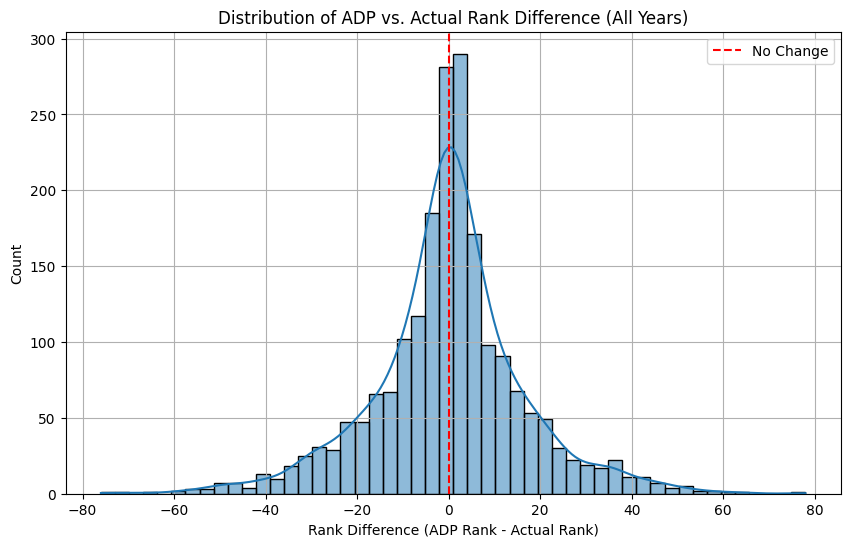

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=combined_results,
    x='Rank_Diff',
    bins=50,
    kde=True
)

plt.title('Distribution of ADP vs. Actual Rank Difference (All Years)')
plt.xlabel('Rank Difference (ADP Rank - Actual Rank)')
plt.ylabel('Count')
plt.grid(True)
plt.axvline(x=0, color='r', linestyle='--', label='No Change')
plt.legend()
plt.savefig('rank_diff_distribution_histogram.png')
plt.show()

Positional Variation (Standard Deviation of Rank_Diff):
POS
WR    19.725493
RB    18.362064
TE     9.952936
QB     5.833585
Name: Rank_Diff, dtype: float64


/var/folders/5b/zyfxmg1n27sc10rqxm40tr3r0000gn/T/ipykernel_27240/2815779416.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positional_variation.index, y=positional_variation.values, palette='viridis')


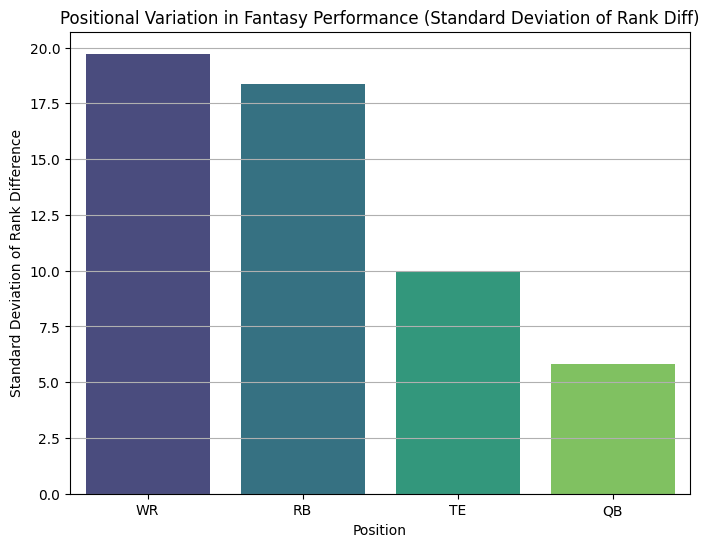

In [5]:
positional_variation = combined_results.groupby('POS')['Rank_Diff'].std().sort_values(ascending=False)

print("Positional Variation (Standard Deviation of Rank_Diff):")
print(positional_variation)

plt.figure(figsize=(8, 6))
sns.barplot(x=positional_variation.index, y=positional_variation.values, palette='viridis')
plt.title('Positional Variation in Fantasy Performance (Standard Deviation of Rank Diff)')
plt.xlabel('Position')
plt.ylabel('Standard Deviation of Rank Difference')
plt.grid(axis='y')
plt.savefig('positional_variation.png')
plt.show()


Yearly Variation (Standard Deviation of Rank_Diff):
Year
2013    20.824133
2017    19.629041
2016    19.129493
2015    19.042663
2012    15.605981
2018    15.507382
2014    14.278634
2020    14.001361
2019    11.711486
2021    10.004212
2022     8.169187
2023     4.394354
2024     1.519109
Name: Rank_Diff, dtype: float64


/var/folders/5b/zyfxmg1n27sc10rqxm40tr3r0000gn/T/ipykernel_27240/2811163797.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_variation.index, y=yearly_variation.values, palette='magma')


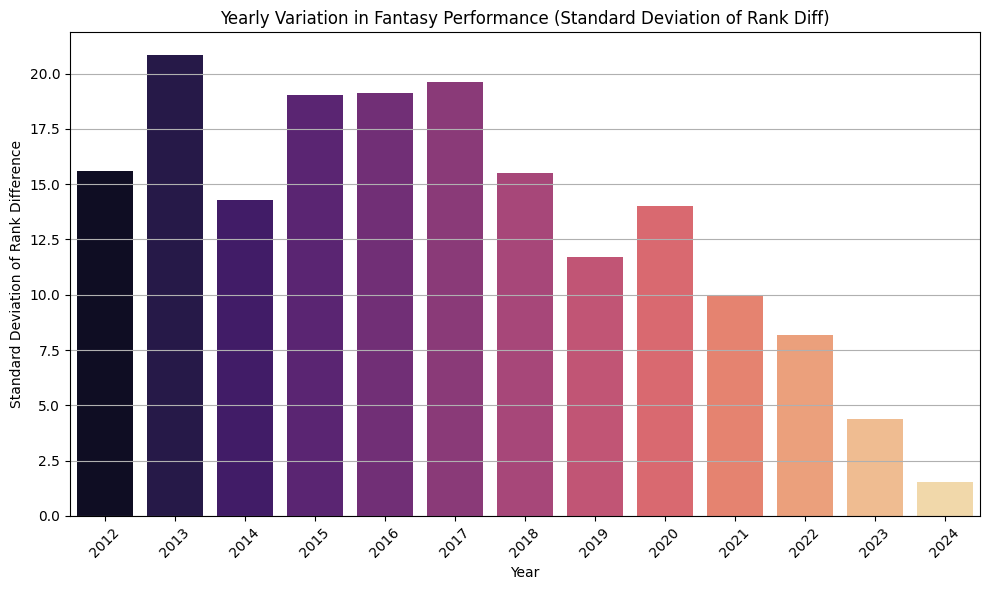

In [6]:
yearly_variation = combined_results.groupby('Year')['Rank_Diff'].std().sort_values(ascending=False)

print("\nYearly Variation (Standard Deviation of Rank_Diff):")
print(yearly_variation)

plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_variation.index, y=yearly_variation.values, palette='magma')
plt.title('Yearly Variation in Fantasy Performance (Standard Deviation of Rank Diff)')
plt.xlabel('Year')
plt.ylabel('Standard Deviation of Rank Difference')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('yearly_variation.png')
plt.show()